# Problem Description

The goal is to develop a predictive model for the Bitcoin to forecast future prices using deep learning algorithms. The recent decade has seen a tremendous surge in the use of digital currencies, which has been one of the most difficult and ambiguous developments in the modern world economy. Investment in crypto assets has a high risk due to the wide changes in cryptocurrency exchange rates, their extreme volatility, and the lack of legal regulation over their transactions in the majority of nations. Therefore, it is crucial for the scientific community as well as financial analysts, investors, and traders to discover appropriate approaches and models for forecasting the pricing of cryptographic products.

We have applied the LSTM deep learning model in this notebook to create predictive models that will forecast the closing price for the following day. In order to prevent bias in our model, we scaled the close price for this. The model uses the last 60 days' closing prices as input to forecast the label's close price for the next day. In order to train and test our models, we built train and test sets using data windowing to obtain the latest 60 days' close price. There are also some visualisations to help you comprehend how cryptocurrency behaves. The steps that must be taken in order to create the prediction models are listed below.

# Importing the Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
!pip install -q yfinance
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from keras.callbacks import EarlyStopping
tf.random.set_seed(1234)

# Loading the dataset

We will load the dataset using yfinance library. It uses a function ticker in which we can pass the name of the cryptocurrency and it will store the data in a variable. Using that we can call the past data to load in the dataframe. Here we are using the past 2 years data for both bitcoin as well as ethereum.

The dataset contains the following columns:

- Date
- Open 
- High 
- Low
- Close
- Volume
- Dividends
- Stock Splits

In [2]:
btc = yf.Ticker('BTC-USD') # Calling the bitcoin data 

bitcoin_df_orig = btc.history(period="2y") # loading the 2 years of data in the dataframe
bitcoin_df = bitcoin_df_orig.copy() # copying the original dataframe to use further when forecasting

# Exploratory data analysis

In this section, we will try to understand both the data to get some insights from them, also to check if our data requires data cleaning or not.

In [3]:
# Return top 5 rows of the ethereum data
bitcoin_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-09-26,10695.575195,10772.999023,10667.281250,10750.723633,46852525493,0,0
2020-09-27,10746.892578,10803.976562,10622.921875,10775.269531,53745972818,0,0
2020-09-28,10776.613281,10945.347656,10703.893555,10709.652344,47762394731,0,0
2020-09-29,10709.650391,10860.000977,10649.495117,10844.640625,46582396602,0,0
2020-09-30,10843.871094,10847.256836,10669.321289,10784.491211,44171073700,0,0


In [4]:
# Return last 5 rows of the bitcoin data
bitcoin_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-09-22,18534.650391,19456.910156,18415.591797,19413.550781,41135767926,0,0
2022-09-23,19412.400391,19464.671875,18617.552734,19297.638672,38896078052,0,0
2022-09-24,19296.990234,19310.197266,18861.974609,18937.011719,26149643168,0,0
2022-09-25,18936.310547,19134.732422,18696.468750,18802.097656,23359966112,0,0
2022-09-26,18809.203125,19274.001953,18725.611328,19094.839844,42294026240,0,0


In [5]:
# Check for the size of the bitcoin data
bitcoin_df.shape

(731, 7)

In [6]:
# Check for the data types of each column and the non null count (bitcoin)
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2020-09-26 to 2022-09-26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          731 non-null    float64
 1   High          731 non-null    float64
 2   Low           731 non-null    float64
 3   Close         731 non-null    float64
 4   Volume        731 non-null    int64  
 5   Dividends     731 non-null    int64  
 6   Stock Splits  731 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 45.7 KB


In [7]:
# Check for any missing value in bitcoin data
bitcoin_df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

As there is no missing value in the dataset, we can ignore the data cleaning step.

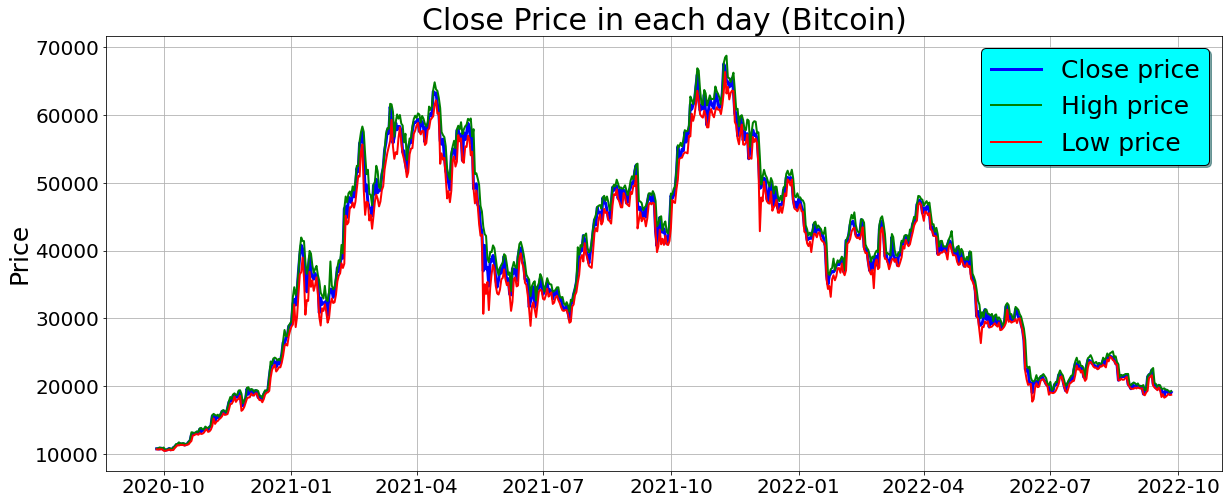

In [8]:
# Visualizing the close, high and low price of bitcoin 
plt.figure(figsize = (20,8))
plt.grid(b=True, which='major', axis='both')
plt.title('Close Price in each day (Bitcoin)', fontsize = 30)
plt.plot(bitcoin_df.index, bitcoin_df['Close'], color='blue', label='Close price', linewidth=3)
plt.plot(bitcoin_df.index, bitcoin_df['High'], color='green', label='High price', linewidth=2)
plt.plot(bitcoin_df.index, bitcoin_df['Low'], color='red', label='Low price', linewidth=2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Price', fontsize = 25)
plt.legend(fontsize=25,shadow=True,facecolor='cyan', edgecolor = 'k')
plt.show()

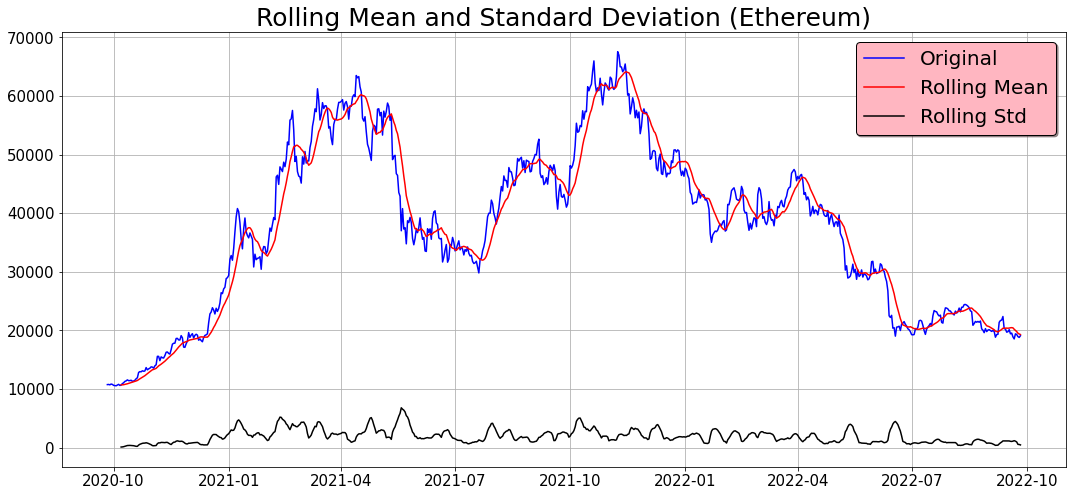

In [9]:
# calculating the rolling mean and standard deviation of the bitcoin and visualizing the same
rolmean = bitcoin_df['Close'].rolling(12).mean() # rolling mean
rolstd = bitcoin_df['Close'].rolling(12).std() # rolling standard deviation

plt.figure(figsize = (18,8))
plt.grid('both')
plt.plot(bitcoin_df['Close'], color='blue',label='Original')# plotting close price
plt.plot(rolmean, color='red', label='Rolling Mean') # plotting rolling mean
plt.plot(rolstd, color='black', label = 'Rolling Std') # plotting standard deviation
plt.legend(loc='best', fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.title('Rolling Mean and Standard Deviation (Ethereum)', fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show(block=False)

# Analysis

In [10]:
bitcoin_df = bitcoin_df[['Close']]

size = int(len(bitcoin_df)*0.2)

# Splitting bitcoin to train and test
bitcoin_train = bitcoin_df.iloc[:-size]
bitcoin_test = bitcoin_df.iloc[-size:]

# Check the shape of the train and test set after splitting 
print('Bitcoin train shape : ', bitcoin_train.shape)
print('Bitcoin test shape : ', bitcoin_test.shape)


# Initializing the scaler for bitcoin data 
scaler = StandardScaler()

# Fitting and transforming the bitcoin train and test data
bitcoin_train['Close'] = scaler.fit_transform(bitcoin_train)
bitcoin_test['Close'] = scaler.transform(bitcoin_test)

Bitcoin train shape :  (585, 1)
Bitcoin test shape :  (146, 1)


In [11]:
window_size = 60

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(window_size, len(bitcoin_train)):
    X_train.append(bitcoin_train.iloc[i-window_size:i].values) 
    y_train.append(bitcoin_train.iloc[i, -1]) # consider Close as target
    
# Change them to numpy array
X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,1)

# Preparing Test dataset

# Concatenate train data to test data
dataset_total = np.concatenate((bitcoin_train, bitcoin_test), axis = 0)
# Split test data and last window-size of train data
inputs = dataset_total[len(dataset_total) - len(bitcoin_test) - window_size:]
# Do the same thing for test data
X_test = []
y_test = []
for i in range(window_size, window_size+len(bitcoin_test)):
    X_test.append(inputs[i-window_size:i, :]) 
    y_test.append(inputs[i, -1]) # consider Close as target
# Change them to numpy array
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1, 1)

# Model Building


The model here used is LSTM. It is special kind of recurrent neural network that is capable of learning long term dependencies in data. This is achieved because the recurring module of the model has a combination of four layers interacting with each other. The model architecture created here is having one LSTM layer with 128 neurons as input layer and after that added a dropout of 0.2. The hidden layer is having 10 neurons and the output layer is having only one layer. The optimizer used is adam with learning rate 0.001 and loss used is mean squared error.

In [12]:
# Initializing the early stop to stop the model at best accuracy
earlystop = EarlyStopping(monitor = 'loss',
                          min_delta = 0,
                          patience = 5,
                          restore_best_weights = True)

model_1 = Sequential()
model_1.add(LSTM(units=128, input_shape = (X_train.shape[1], X_train.shape[2])))
model_1.add(Dropout(0.2))
model_1.add(Dense(units=10))
model_1.add(Dense(units=1))
adamopt = Adam(lr=0.001)
model_1.compile(optimizer = adamopt, loss = 'mse')
model_1_history = model_1.fit(X_train, y_train, epochs = 30, batch_size = 100, callbacks = earlystop)

Epoch 1/30
6/6 [==============================] - 18s 281ms/step - loss: 0.5215
Epoch 2/30
6/6 [==============================] - 1s 201ms/step - loss: 0.1369
Epoch 3/30
6/6 [==============================] - 1s 212ms/step - loss: 0.0777
Epoch 4/30
6/6 [==============================] - 1s 190ms/step - loss: 0.0762
Epoch 5/30
6/6 [==============================] - 2s 267ms/step - loss: 0.0585
Epoch 6/30
6/6 [==============================] - 1s 185ms/step - loss: 0.0527
Epoch 7/30
6/6 [==============================] - 1s 207ms/step - loss: 0.0501
Epoch 8/30
6/6 [==============================] - 1s 216ms/step - loss: 0.0459
Epoch 9/30
6/6 [==============================] - 1s 260ms/step - loss: 0.0439
Epoch 10/30
6/6 [==============================] - 2s 299ms/step - loss: 0.0424
Epoch 11/30
6/6 [==============================] - 1s 211ms/step - loss: 0.0425
Epoch 12/30
6/6 [==============================] - 1s 164ms/step - loss: 0.0418
Epoch 13/30
6/6 [==============================]

5/5 [==============================] - 3s 27ms/step
RMSE : 0.12018693263284609


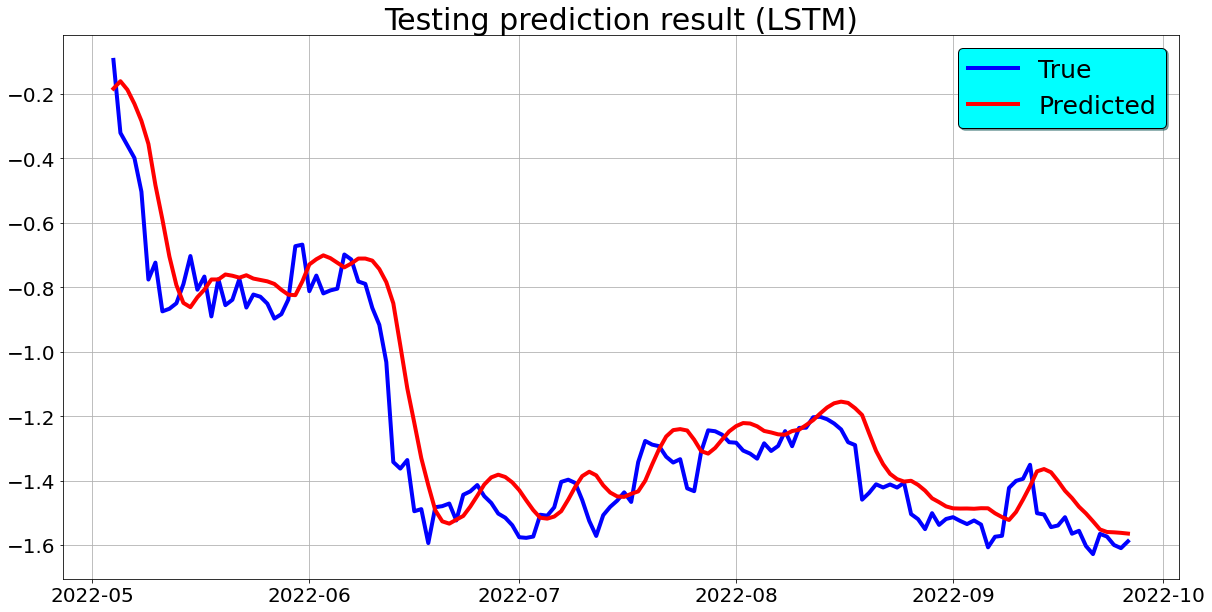

In [14]:
# Predicting on the test data
test_predict_1 = model_1.predict(X_test)

# Calculating the rmse value for the predictions and the actual test values
print('RMSE :', np.sqrt(mean_squared_error(y_test, test_predict_1)))

In [24]:
# Calculating the accuarcy score 
accuracy1 = r2_score(y_test, test_predict_1)*100
print('Accuracy score of LSTM : ', round(accuracy1,2))

Accuracy score of LSTM :  86.9


# Hyperparameter Tuning

In [29]:
model_2 = Sequential()
model_2.add(LSTM(units=256, input_shape = (X_train.shape[1], X_train.shape[2])))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=10))
model_2.add(Dense(units=1))
adamopt = Adam(lr=0.001)
model_2.compile(optimizer = adamopt, loss = 'mse')
model_2_history = model_2.fit(X_train, y_train, epochs = 30, batch_size = 100, callbacks = earlystop)

Epoch 1/30
6/6 [==============================] - 20s 475ms/step - loss: 0.3256
Epoch 2/30
6/6 [==============================] - 3s 411ms/step - loss: 0.0665
Epoch 3/30
6/6 [==============================] - 3s 539ms/step - loss: 0.0567
Epoch 4/30
6/6 [==============================] - 3s 513ms/step - loss: 0.0500
Epoch 5/30
6/6 [==============================] - 3s 485ms/step - loss: 0.0413
Epoch 6/30
6/6 [==============================] - 3s 556ms/step - loss: 0.0384
Epoch 7/30
6/6 [==============================] - 4s 629ms/step - loss: 0.0368
Epoch 8/30
6/6 [==============================] - 3s 543ms/step - loss: 0.0353
Epoch 9/30
6/6 [==============================] - 3s 473ms/step - loss: 0.0353
Epoch 10/30
6/6 [==============================] - 3s 483ms/step - loss: 0.0324
Epoch 11/30
6/6 [==============================] - 3s 563ms/step - loss: 0.0325
Epoch 12/30
6/6 [==============================] - 3s 524ms/step - loss: 0.0317
Epoch 13/30
6/6 [==============================]

In [30]:
# Predicting on the test data
test_predict_2 = model_2.predict(X_test)

# Calculating the rmse value for the predictions and the actual test values
print('RMSE :', np.sqrt(mean_squared_error(y_test, test_predict_2)))

5/5 [==============================] - 5s 141ms/step
RMSE : 0.10129119276882277


In [31]:
# Calculating the accuarcy score 
accuracy2 = r2_score(y_test, test_predict_2)*100
print('Accuracy score of LSTM : ', round(accuracy2,2))

Accuracy score of LSTM :  90.7


In [32]:
model_3 = Sequential()
model_3.add(LSTM(units=64, input_shape = (X_train.shape[1], X_train.shape[2])))
model_3.add(Dropout(0.5))
model_3.add(Dense(units=10))
model_3.add(Dense(units=1))
adamopt = Adam(lr=0.01)
model_3.compile(optimizer = adamopt, loss = 'mse')
model_3_history = model_3.fit(X_train, y_train, epochs = 30, batch_size = 100, callbacks = earlystop)

Epoch 1/30
6/6 [==============================] - 16s 97ms/step - loss: 0.3246
Epoch 2/30
6/6 [==============================] - 1s 121ms/step - loss: 0.1223
Epoch 3/30
6/6 [==============================] - 1s 82ms/step - loss: 0.0690
Epoch 4/30
6/6 [==============================] - 1s 86ms/step - loss: 0.0552
Epoch 5/30
6/6 [==============================] - 1s 103ms/step - loss: 0.0493
Epoch 6/30
6/6 [==============================] - 1s 113ms/step - loss: 0.0434
Epoch 7/30
6/6 [==============================] - 1s 98ms/step - loss: 0.0413
Epoch 8/30
6/6 [==============================] - 1s 111ms/step - loss: 0.0405
Epoch 9/30
6/6 [==============================] - 1s 130ms/step - loss: 0.0388
Epoch 10/30
6/6 [==============================] - 1s 85ms/step - loss: 0.0381
Epoch 11/30
6/6 [==============================] - 1s 114ms/step - loss: 0.0403
Epoch 12/30
6/6 [==============================] - 1s 96ms/step - loss: 0.0329
Epoch 13/30
6/6 [==============================] - 1s 

In [33]:
# Predicting on the test data
test_predict_3 = model_3.predict(X_test)

# Calculating the rmse value for the predictions and the actual test values
print('RMSE :', np.sqrt(mean_squared_error(y_test, test_predict_3)))

5/5 [==============================] - 4s 19ms/step
RMSE : 0.1325222493455143


In [34]:
# Calculating the accuarcy score 
accuracy3 = r2_score(y_test, test_predict_3)*100
print('Accuracy score of LSTM : ', round(accuracy3,2))

Accuracy score of LSTM :  84.07


In hypertuning the parameter, we have used two models, one with changing the LSTM layer to 256 neurons and adding one more hidden layer with 64 neurons. For the second model, the neurons is decreased from 128 to 64 and increased the dropout of 0.5. The second model we have created is giving more accuracy than the other two that is 90%.



# Result and Model Evaluation

In [35]:
# Predicting on the test data
test_predict_2 = model_2.predict(X_test)

# Calculating the rmse value for the predictions and the actual test values
print('RMSE :', np.sqrt(mean_squared_error(y_test, test_predict_2)))

5/5 [==============================] - 1s 104ms/step
RMSE : 0.10129119276882277


In [36]:
# Calculating the accuarcy score 
accuracy2 = r2_score(y_test, test_predict_2)*100
print('Accuracy score of LSTM : ', round(accuracy2,2))

Accuracy score of LSTM :  90.7


5/5 [==============================] - 0s 34ms/step
RMSE : 0.10129119276882277


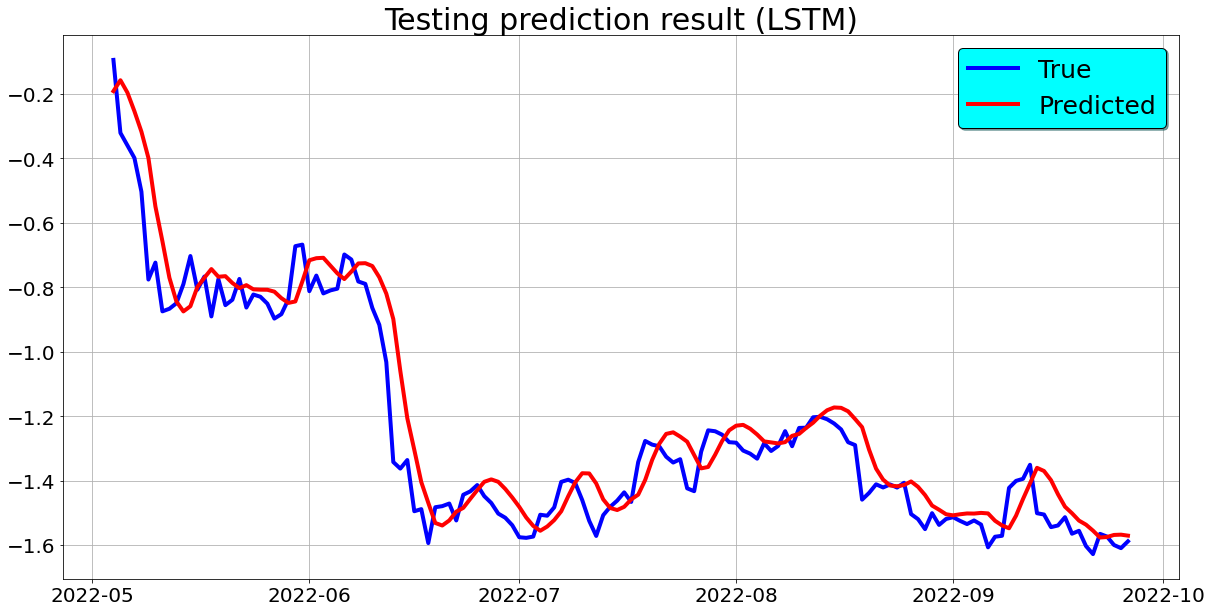

In [37]:
# Predicting on the test data
test_predict_2 = model_2.predict(X_test)

# Calculating the rmse value for the predictions and the actual test values
print('RMSE :', np.sqrt(mean_squared_error(y_test, test_predict_2)))

# Visualizing the actual test and predicted values
plt.figure(figsize = (20,10))
plt.grid(b=True, which='major', axis='both')
plt.title('Testing prediction result (LSTM)', fontsize = 30)
plt.plot(bitcoin_test.index, y_test,linewidth = 4, label='True', color = 'blue')
plt.plot(bitcoin_test.index, test_predict_2, linewidth = 4,color = 'red', label='Predicted')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize=25,shadow=True,facecolor='cyan', edgecolor = 'k')
plt.show()

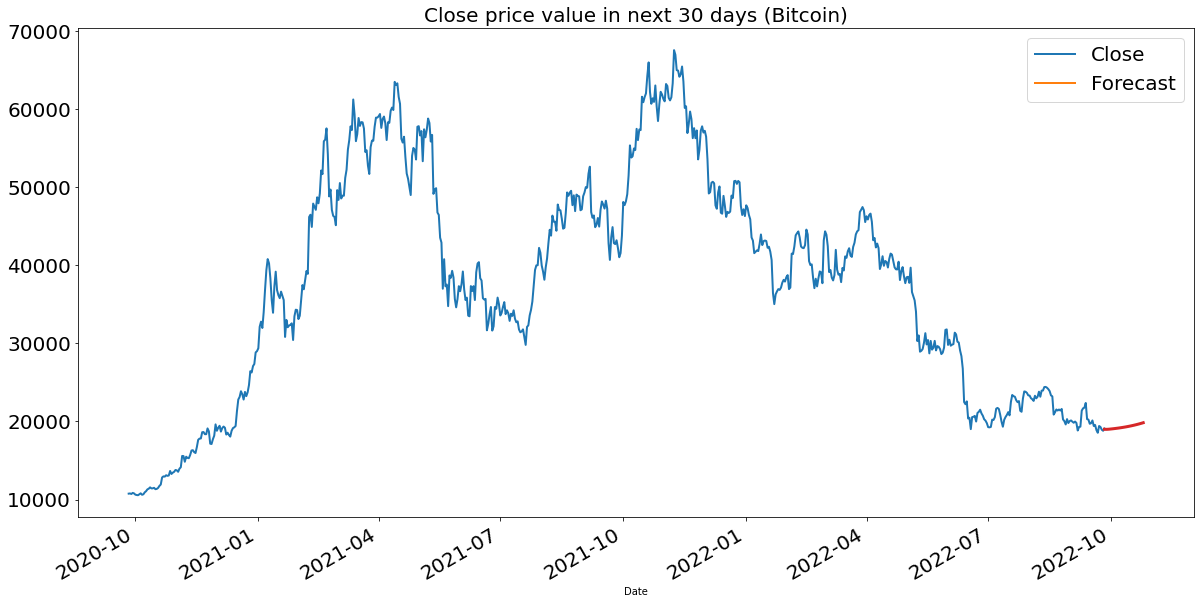

In [43]:
x_input=X_test[-1:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
lst_output=[]
n_steps = 60
i=0
forecast = []
while(i<30):
    
    if(len(temp_input)>60):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        
        x_input = x_input.reshape((1, n_steps, 1))
        forecast.append(x_input)
        yhat = model_1.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        forecast.append(x_input)
        yhat = model_1.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    
df3=scaler.inverse_transform(lst_output)
df1=scaler.inverse_transform(bitcoin_test).tolist()
df1.extend(df3)
today = datetime.datetime.now().strftime('%m/%d/%Y')
forecast_dates=pd.date_range(start=today, periods=30)
forecast=pd.DataFrame(forecast_dates,columns=['Date'])
forecast['Date']=pd.to_datetime(forecast['Date'])
forecast.sort_values('Date',inplace=True)
forecast['Close']=df3
forecast.set_index('Date',inplace=True)
result_df=pd.concat([bitcoin_df_orig['Close'],forecast])

ax = result_df[:-29].plot(figsize=(20,10),linewidth=2,fontsize=20,grid=True)
result_df[-30:].plot(ax=ax,linewidth=3)
plt.title('Close price value in next 30 days (Bitcoin)', fontsize = 20)
plt.legend(['Close','Forecast'],fontsize=20)
plt.show()